### word2vec + UMAP + HDBSCAN

Dataset: "Amazon Reviews: Musical Instruments" from https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/

In [1]:
# import pandas as pd
import json

folder_path = "D:/WUT/NLP/"
data_path = folder_path + "Musical_Instruments.json"
meta_path = folder_path + "meta_Musical_Instruments.json"

def read_json_array(path):
  data = []
  with open(path, 'r') as file:
    for line in file:
      json_object = json.loads(line.strip())
      data.append(json_object)
  return data

data = read_json_array(data_path)
meta = read_json_array(meta_path)

In [2]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gensim.models import Word2Vec
import numpy as np
import umap # pip install umap-learn
import hdbscan
import matplotlib.pyplot as plt

c:\ProgramFiles\Anaconda3\envs\nlp10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Step 1: Prepare the text data
texts = [review['reviewText'] for review in data if 'reviewText' in review]
print(f'Amount: {len(texts)}')


Amount: 1511675


In [4]:
# Step 2: Tokenize and clean text
def tokenize(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and lowercase
    tokens = text.split()  # Simple split by spaces
    tokens = [token for token in tokens if token not in ENGLISH_STOP_WORDS]  # Remove stopwords
    return tokens

tokenized_texts = [tokenize(text) for text in texts]


In [5]:
# Step 3: Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=50, window=5, min_count=1, workers=4)

In [6]:
# Step 4: Compute average word vectors for each review
def average_word_vectors(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

review_vectors = np.array([average_word_vectors(tokens, w2v_model) for tokens in tokenized_texts])


In [9]:
# Step 5: Dimensionality reduction using UMAP
# reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=2024, n_epochs=200)
# reduced_vectors = reducer.fit_transform(review_vectors)

subset = review_vectors[:5000]  # Use the first 5000 samples

# Fit UMAP on the subset
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=2024)
reducer.fit(subset)

# Transform the remaining data
embedding_subset = reducer.transform(subset)
embedding_rest = reducer.transform(review_vectors[5000:])

# Combine embeddings
reduced_vectors = np.vstack([embedding_subset, embedding_rest])

c:\ProgramFiles\Anaconda3\envs\nlp10\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
# Step 6: Clustering using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=3, metric='euclidean')
labels = clusterer.fit_predict(reduced_vectors)


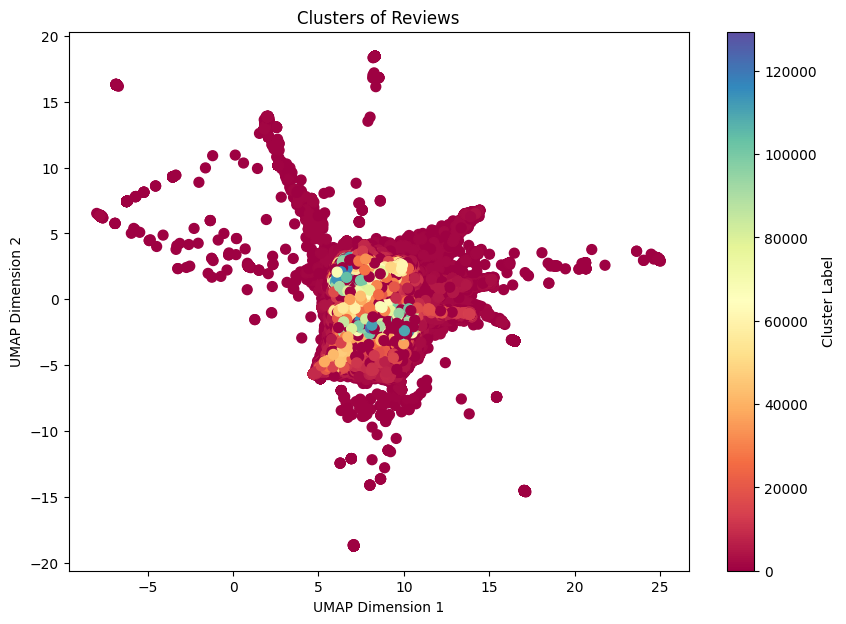

In [11]:
# Step 7: Visualization (optional)
plt.figure(figsize=(10, 7))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=labels, cmap='Spectral', s=50)
plt.colorbar(label='Cluster Label')
plt.title('Clusters of Reviews')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [ ]:
# Output the clusters
# print("Output removed")
clusters = {label: [] for label in set(labels) if label != -1}
for i, label in enumerate(labels):
    if label != -1:
        clusters[label].append(data[i])

print("Clusters of Reviews:")
for label, cluster in clusters.items():
    print(f"Cluster {label}:")
    for review in cluster:
        if 'reviewText' in review:
            print(f"  - {review['reviewText'][:100]}...")
        else:
            print(f"missing reviewText")

Output removed


In [17]:
converted_clusters = {str(key): value for key, value in clusters.items()}

output_path = 'results/amazon_musical_instruments_hdbscan.json'
with open(output_path, 'w') as jsonfile:
    json.dump(converted_clusters, jsonfile, indent=4)

print(f"Clusters saved to {output_path}.")

Clusters saved to results/amazon_musical_instruments_hdbscan.json.


In [ ]:
output_path = 'results/amazon_musical_instruments_umap.npy'
np.save(output_path, reduced_vectors) # use np.load() to restore
print(f"UMAP vectors saved to {output_path}.")

UMAP vectors saved to results/amazon_musical_instruments_umap.npy.
